# $k$-means clustering (Assignment 6)

### Name: Ankit Saha
### Roll number: AI21BTECH11004

In [184]:
using CSV
using DataFrames
using Random
using Plots
using PlotlyJS
using LaTeXStrings
using Dates

Random.seed!(0)

TaskLocalRNG()

In [185]:
INFILE = "dow_jones_index.csv"
OUTFILE = "output.csv"
CLUSTERS = 4
MAX_ITERS = 100
EPSILON = 1e-5

1.0e-5

## Data loading

In [186]:
df = DataFrame(CSV.File(INFILE))
delete!(df, [1])
df[!, 1] = parse.(Float64, df[!, 1])
rename!(df, "Data Description Line 1" => "Column1")
SAMPLES = nrow(df)
df

Row,Column1,Column2,Column3,Column4,Column5,Column6
,Float64,Float64?,Int64?,Float64?,Int64?,Float64?
1,16.72,15.78,239655616,3.79267,26,0.182704
2,16.71,15.64,242963398,-4.42849,19,0.187852
3,16.38,15.6,138428495,-2.47066,12,0.189994
4,16.63,15.82,151379173,1.63831,5,0.185989
5,17.39,16.18,154387761,5.93325,97,0.175029
6,17.48,16.97,114691279,0.230814,90,0.172712
7,17.68,17.28,80023895,-0.632547,83,0.173611
8,17.15,15.96,132981863,-1.76678,76,0.179856
9,16.94,16.13,109493077,-1.36823,69,0.180941


## Standardizing the data
$$x \mapsto \frac{x - \mu}{\sigma}$$\
makes the mean and standard deviation of each column $0$ and $1$ respectively 

Standardizing is being done because the range of values of each features is vastly different \
Without standardizing, the values in "Column3" would dominate in calculating the distance between vectors

In [187]:
for j = 1:6
    mean = 0
    std = 0 
    for i = 1:SAMPLES
        mean += df[i, j] / SAMPLES
    end
    for i = 1:SAMPLES
        std += (df[i, j] - mean)^2 / SAMPLES
    end
    std = sqrt(std)  
    df[!, j] .= (df[!, j] .- mean) ./ std
end

df

Row,Column1,Column2,Column3,Column4,Column5,Column6
,Float64,Float64,Float64,Float64,Float64,Float64
1,-1.14328,-1.14837,0.771212,1.48737,-0.572849,-1.66773
2,-1.14359,-1.15273,0.792103,-1.78002,-0.724024,-1.65087
3,-1.15353,-1.15398,0.131879,-1.0019,-0.875198,-1.64385
4,-1.146,-1.14712,0.213673,0.631147,-1.02637,-1.65697
5,-1.1231,-1.13591,0.232675,2.33811,0.960489,-1.69287
6,-1.12039,-1.11129,-0.0180413,0.0717577,0.809315,-1.70046
7,-1.11436,-1.10164,-0.236994,-0.271373,0.65814,-1.69752
8,-1.13033,-1.14276,0.0974788,-0.722158,0.506966,-1.67706
9,-1.13666,-1.13746,-0.0508722,-0.56376,0.355792,-1.67351


In [188]:
describe(df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,Column1,5.32907e-18,-1.31741,-0.234531,3.58109,0,Float64
2,Column2,-9.38361e-16,-1.31598,-0.244258,3.5884,0,Float64
3,Column3,4.75527e-16,-0.681029,-0.407288,8.43725,0,Float64
4,Column4,7.34227e-17,-6.14959,-0.0199761,3.90758,0,Float64
5,Column5,1.49064e-15,-1.13435,-0.119327,6.12201,0,Float64
6,Column6,-3.98777e-15,-2.05141,-0.0352435,2.85767,0,Float64


Create a new column to store the cluster id of each data sample

In [189]:
df[!, :id] .= 0
df

Row,Column1,Column2,Column3,Column4,Column5,Column6,id
,Float64,Float64,Float64,Float64,Float64,Float64,Int64
1,-1.14328,-1.14837,0.771212,1.48737,-0.572849,-1.66773,0
2,-1.14359,-1.15273,0.792103,-1.78002,-0.724024,-1.65087,0
3,-1.15353,-1.15398,0.131879,-1.0019,-0.875198,-1.64385,0
4,-1.146,-1.14712,0.213673,0.631147,-1.02637,-1.65697,0
5,-1.1231,-1.13591,0.232675,2.33811,0.960489,-1.69287,0
6,-1.12039,-1.11129,-0.0180413,0.0717577,0.809315,-1.70046,0
7,-1.11436,-1.10164,-0.236994,-0.271373,0.65814,-1.69752,0
8,-1.13033,-1.14276,0.0974788,-0.722158,0.506966,-1.67706,0
9,-1.13666,-1.13746,-0.0508722,-0.56376,0.355792,-1.67351,0


#### Function to calculate the Euclidean distance between two data vectors

In [190]:
distance(x, y) =
begin
    d = 0
    for i = 1:6
        d += (x[i] - y[i])^2
    end
    return sqrt(d)
end    

distance (generic function with 1 method)

### Start the clock for measuring the time taken by the algorithm

In [191]:
start_time = now()

2022-12-04T00:04:59.241

## Selecting random cluster centers

In [192]:
center_indices = shuffle(1:SAMPLES)[1:CLUSTERS]
for i = 1:CLUSTERS
    df[center_indices[i], :id] = i
end
print(center_indices)

[706, 315, 678, 45]

In [193]:
centers = []
for i = 1:CLUSTERS
    append!(centers, [df[center_indices[i], :]])
end
centers

4-element Vector{Any}:
 DataFrameRow
 Row │ Column1  Column2  Column3    Column4    Column5   Column6    id    
     │ Float64  Float64  Float64    Float64    Float64   Float64    Int64 
─────┼────────────────────────────────────────────────────────────────────
 706 │ 1.04176  1.05957  -0.603325  -0.451289  0.787718  -0.469259      1
 DataFrameRow
 Row │ Column1   Column2   Column3    Column4   Column5    Column6    id    
     │ Float64   Float64   Float64    Float64   Float64    Float64    Int64 
─────┼──────────────────────────────────────────────────────────────────────
 315 │ 0.778157  0.820611  -0.638378  0.441224  -0.572849  -0.509914      2
 DataFrameRow
 Row │ Column1    Column2    Column3   Column4    Column5   Column6  id    
     │ Float64    Float64    Float64   Float64    Float64   Float64  Int64 
─────┼─────────────────────────────────────────────────────────────────────
 678 │ -0.684765  -0.673259  0.243048  -0.447597  0.183022  2.23971      3
 DataFrameRow
 Row │ Colum

#### Function to compute the cluster a given vector is assigned based on the closest cluster center

In [194]:
function assignCluster(i)
    min_dist = Inf
    id = 0
    for k = 1:CLUSTERS
        d = distance(df[i, :], centers[k])
        if d < min_dist
            min_dist = d
            id = centers[k]["id"]
        end
    end
    df[i, :id] = id    
end

assignCluster (generic function with 1 method)

#### Function to compute the total cluster variance ($J_{\text{cluster}}$)
$$J_{\text{cluster}} = \sum_{k} \sum_{i \in k} \frac{||\overrightarrow{x_i} - \overrightarrow{\mu_k}||^2}{N_k} $$

In [195]:
clusterVariance() = 
begin
    J_cluster = 0
    for k = 1:CLUSTERS
        J = 0
        cnt = 0
        for i = 1:SAMPLES
            if df[i, "id"] == k
                J += distance(df[i, :], centers[k])^2
                cnt += 1
            end
        end
        J_cluster += J / cnt
    end
    return J_cluster
end

clusterVariance (generic function with 1 method)

#### Function to recompute the cluster centers after each iteration
$$\overrightarrow{\mu_k}^{(t+1)} = \frac{1}{N_k^{(t)}} \sum_{i \in k} \overrightarrow{x_i}^{(t)} $$

In [196]:
function recomputeCenters()
    for k = 1:CLUSTERS
        sm = zeros(6,1)
        cnt = 0
        for i = 1:SAMPLES
            if df[i, :id] == k
                for j = 1:6
                    sm[j] += df[i, j]
                    cnt += 1
                end
            end
        end
        for l = 1:6
            centers[k][l] = sm[l] / cnt
        end
    end
end

recomputeCenters (generic function with 1 method)

## First iteration 

In [197]:
for i = 1:SAMPLES
    if df[i, :id] == 0
        assignCluster(i)
    end
end

df

Row,Column1,Column2,Column3,Column4,Column5,Column6,id
,Float64,Float64,Float64,Float64,Float64,Float64,Int64
1,-1.14328,-1.14837,0.771212,1.48737,-0.572849,-1.66773,2
2,-1.14359,-1.15273,0.792103,-1.78002,-0.724024,-1.65087,4
3,-1.15353,-1.15398,0.131879,-1.0019,-0.875198,-1.64385,2
4,-1.146,-1.14712,0.213673,0.631147,-1.02637,-1.65697,2
5,-1.1231,-1.13591,0.232675,2.33811,0.960489,-1.69287,2
6,-1.12039,-1.11129,-0.0180413,0.0717577,0.809315,-1.70046,2
7,-1.11436,-1.10164,-0.236994,-0.271373,0.65814,-1.69752,2
8,-1.13033,-1.14276,0.0974788,-0.722158,0.506966,-1.67706,1
9,-1.13666,-1.13746,-0.0508722,-0.56376,0.355792,-1.67351,2


In [198]:
J_iters = [clusterVariance()]
print(J_iters)

[21.470336643785124]

In [199]:
recomputeCenters()
centers

4-element Vector{Any}:
 DataFrameRow
 Row │ Column1   Column2   Column3    Column4     Column5   Column6     id    
     │ Float64   Float64   Float64    Float64     Float64   Float64     Int64 
─────┼────────────────────────────────────────────────────────────────────────
 706 │ 0.120553  0.118982  -0.071762  -0.0971214  0.139288  -0.0284231      1
 DataFrameRow
 Row │ Column1    Column2    Column3     Column4    Column5     Column6     id ⋯
     │ Float64    Float64    Float64     Float64    Float64     Float64     In ⋯
─────┼──────────────────────────────────────────────────────────────────────────
 315 │ 0.0465376  0.0471151  -0.0607519  0.0701248  -0.0590039  -0.0524222     ⋯
                                                                1 column omitted
 DataFrameRow
 Row │ Column1    Column2    Column3   Column4     Column5       Column6   id  ⋯
     │ Float64    Float64    Float64   Float64     Float64       Float64   Int ⋯
─────┼───────────────────────────────────────────────

## Remaining iterations (until convergence)

In [200]:
iterations = MAX_ITERS
for iteration = 2:MAX_ITERS
    for i = 1:SAMPLES
        assignCluster(i)
    end
    recomputeCenters()
    append!(J_iters, clusterVariance())
    if abs(J_iters[end] - J_iters[end-1]) < EPSILON
        iterations = iteration
        break
    end
end

df

Row,Column1,Column2,Column3,Column4,Column5,Column6,id
,Float64,Float64,Float64,Float64,Float64,Float64,Int64
1,-1.14328,-1.14837,0.771212,1.48737,-0.572849,-1.66773,4
2,-1.14359,-1.15273,0.792103,-1.78002,-0.724024,-1.65087,4
3,-1.15353,-1.15398,0.131879,-1.0019,-0.875198,-1.64385,4
4,-1.146,-1.14712,0.213673,0.631147,-1.02637,-1.65697,4
5,-1.1231,-1.13591,0.232675,2.33811,0.960489,-1.69287,2
6,-1.12039,-1.11129,-0.0180413,0.0717577,0.809315,-1.70046,4
7,-1.11436,-1.10164,-0.236994,-0.271373,0.65814,-1.69752,4
8,-1.13033,-1.14276,0.0974788,-0.722158,0.506966,-1.67706,4
9,-1.13666,-1.13746,-0.0508722,-0.56376,0.355792,-1.67351,4


### Stop the clock for measuring the time taken by the algorithm

In [201]:
end_time = now()

2022-12-04T00:04:59.548

## Plotting cluster variance along the number of iterations

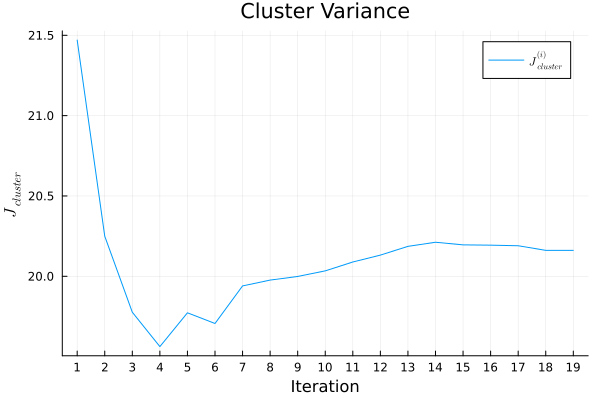

In [202]:
Plots.plot(1:iterations, J_iters, label=L"$J_{cluster}^{(i)}$", xticks=(1:iterations, 1:iterations))
xlabel!("Iteration")
ylabel!(L"$J_{cluster}$")
title!("Cluster Variance")

## Results

In [203]:
println("Number of iterations for convergence = ", iterations)
print("Total time taken for clustering = ", end_time - start_time)

Number of iterations for convergence = 19
Total time taken for clustering = 307 milliseconds

In [204]:
number_per_cluster = [0, 0, 0, 0]
for k = 1:CLUSTERS
    for i = 1:SAMPLES
        if df[i, :id] == k
            number_per_cluster[k] += 1
        end
    end
end
println("The number of samples in each cluster is")
print(number_per_cluster)

The number of samples in each cluster is
[272, 113, 172, 193]

Writing the clustering output to output.csv

Output format:
- Firstly, each input vector along with the cluster assigned to it
- After an empty line, the number of iterations required to converge
- Followed by four lines containing the number of input vectors in each cluster

In [205]:
df2 = DataFrame(CSV.File(INFILE))
delete!(df2, [1])
df2[!, 1] = parse.(Float64, df2[!, 1])
df2[!, :id] = df[!, :id]

CSV.write(OUTFILE, df2, header=false)
open(OUTFILE, "a") do outfile
    println(outfile, "")
    println(outfile, string(iterations))
    println(outfile, "")
    for n in number_per_cluster
        println(outfile, string(n))
    end
end